In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
from time import time
from collections import Counter
from datetime import datetime, timedelta
from tqdm import tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import yfinance as yf

from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GRU, Bidirectional,
                                     Embedding, BatchNormalization, Dropout)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

np.random.seed(42)
tf.random.set_seed(42)
idx = pd.IndexSlice

sns.set_style('whitegrid')

Using GPU


In [3]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

deciles = np.arange(.1, 1, .1).round(1)

In [4]:
data_path = Path('data', 'sec-filings')
results_path = Path('results', 'sec-filings')

selected_section_path = results_path / 'ngrams_1'
ngram_path = results_path / 'ngrams'
vector_path = results_path / 'vectors'

for path in [vector_path, selected_section_path, ngram_path]:
    if not path.exists():
        path.mkdir(parents=True)

In [5]:
# Get filing info
filing_index = (pd.read_csv(data_path / 'filing_index.csv', parse_dates=['DATE_FILED'])
                .rename(columns=str.lower))
filing_index.index += 1
filing_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 1 to 22631
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cik           22631 non-null  int64         
 1   company_name  22631 non-null  object        
 2   form_type     22631 non-null  object        
 3   date_filed    22631 non-null  datetime64[ns]
 4   edgar_link    22631 non-null  object        
 5   quarter       22631 non-null  int64         
 6   ticker        22631 non-null  object        
 7   sic           22461 non-null  object        
 8   exchange      20619 non-null  object        
 9   hits          22555 non-null  object        
 10  year          22631 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.9+ MB


In [6]:
filing_index.head()

,cik,company_name,form_type,date_filed,edgar_link,quarter,ticker,sic,exchange,hits,year
1,1000180,SANDISK CORP,10-K,2013-02-19,edgar/data/1000180/0001000180-13-000009.txt,1,SNDK,3572,NASDAQ,3,2013
2,1000209,MEDALLION FINANCIAL CORP,10-K,2013-03-13,edgar/data/1000209/0001193125-13-103504.txt,1,TAXI,6199,NASDAQ,0,2013
3,1000228,HENRY SCHEIN INC,10-K,2013-02-13,edgar/data/1000228/0001000228-13-000010.txt,1,HSIC,5047,NASDAQ,3,2013
4,1000229,CORE LABORATORIES N V,10-K,2013-02-19,edgar/data/1000229/0001000229-13-000009.txt,1,CLB,1389,NYSE,2,2013
5,1000232,KENTUCKY BANCSHARES INC KY,10-K,2013-03-28,edgar/data/1000232/0001104659-13-025094.txt,1,KTYB,6022,OTC,0,2013


In [7]:
filing_index.ticker.nunique()

6630

In [8]:
filing_index.date_filed.describe()

count                   22631
unique                    980
top       2014-03-31 00:00:00
freq                      442
first     2013-01-02 00:00:00
last      2016-12-30 00:00:00
Name: date_filed, dtype: object

In [9]:
# Download stock price data using Yfinance
yf_data, missing = [], []
for i, (symbol, dates) in enumerate(filing_index.groupby('ticker').date_filed, 1):

    if i % 250 == 0:
        print(i, len(yf_data), len(set(missing)), flush=True)

    ticker = yf.Ticker(symbol)
    for filing, date in dates.to_dict().items():
        start = date - timedelta(days=93)
        end = date + timedelta(days=31)
        df = ticker.history(start=start, end=end)
        if df.empty:
            missing.append(symbol)
        else:
            yf_data.append(df.assign(ticker=symbol, filing=filing))

yf_data = pd.concat(yf_data).rename(columns=str.lower)
yf_data.info()

- AAC: Data doesn't exist for startDate = 1372431600, endDate = 1383145200
- AAC: Data doesn't exist for startDate = 1403881200, endDate = 1414594800
- AAC: Data doesn't exist for startDate = 1436626800, endDate = 1447340400
- AAMC: Data doesn't exist for startDate = 1352127600, endDate = 1362841200
- AAMC: Data doesn't exist for startDate = 1384786800, endDate = 1395500400
- AAMC: Data doesn't exist for startDate = 1417186800, endDate = 1427900400
- AAMC: Data doesn't exist for startDate = 1448636400, endDate = 1459350000
- AAN: Data doesn't exist for startDate = 1353423600, endDate = 1364137200
- AAN: Data doesn't exist for startDate = 1385132400, endDate = 1395846000
- AAN: Data doesn't exist for startDate = 1417186800, endDate = 1427900400
- AAN: Data doesn't exist for startDate = 1448636400, endDate = 1459350000
- AAPH: No data found, symbol may be delisted
- AAPH: No data found, symbol may be delisted
- AARI: No data found for this date range, symbol may be delisted
- AARI: No da

In [ ]:
yf_data.to_hdf(results_path / 'sec_returns.h5', 'data/yfinance')
yf_data = pd.read_hdf(results_path / 'sec_returns.h5', 'data/yfinance')
yf_data.ticker.nunique()

In [14]:
# Get (some) missing prices from Quandl
to_do = (filing_index.loc[~filing_index.ticker.isin(yf_data.ticker.unique()), ['ticker', 'date_filed']])
to_do.date_filed.min()
quandl_tickers = (pd.read_hdf('data/assets.h5', 'quandl/wiki/prices').loc[idx['2012':, :], :]
                  .index.unique('ticker'))
quandl_tickers = list(set(quandl_tickers).intersection(set(to_do.ticker)))
print(f'{len(quandl_tickers)}')

to_do = filing_index.loc[filing_index.ticker.isin(quandl_tickers), ['ticker', 'date_filed']]
to_do.info()

ohlcv = ['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']
quandl = (pd.read_hdf('data/assets.h5', 'quandl/wiki/prices').loc[idx['2012': , quandl_tickers], ohlcv]
          .rename(columns=lambda x: x.replace('adj_', '')))

quandl.info()

1179
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4238 entries, 1 to 22627
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ticker      4238 non-null   object        
 1   date_filed  4238 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 99.3+ KB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1471083 entries, (Timestamp('2012-01-02 00:00:00'), 'TAM') to (Timestamp('2018-03-27 00:00:00'), 'ZNGA')
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1470624 non-null  float64
 1   high    1471048 non-null  float64
 2   low     1471048 non-null  float64
 3   close   1471083 non-null  float64
 4   volume  1471083 non-null  float64
dtypes: float64(5)
memory usage: 62.5+ MB


In [15]:
quandl.tail()

open   high    low  close      volume
date       ticker                                        
2018-03-27 ZAGG    12.30  12.65  12.10  12.15    330057.0
           ZEN     49.26  50.15  47.24  47.52   1928585.0
           ZGNX    40.40  40.40  38.10  38.50    429497.0
           ZIXI     4.43   4.45   4.35   4.39    207304.0
           ZNGA     3.85   3.85   3.68   3.70  11026010.0

In [17]:
quandl_data = []
for i, (symbol, dates) in enumerate(to_do.groupby('ticker').date_filed, 1):
    if i % 100 == 0:
        print(i, end=' ', flush=True)
    for filing, date in dates.to_dict().items():
        start = date - timedelta(days=93)
        end = date + timedelta(days=31)
        print(f'i:{i} | filing:{filing} | date:{start} ~ {end}')
        try:
            quandl_data.append(quandl.loc[idx[start:end, symbol], :].reset_index('ticker').assign(filing=filing))
        except Exception as e:
            continue
            print(e)

quandl_data = pd.concat(quandl_data)
quandl_data.to_hdf(results_path / 'sec_returns.h5', 'data/quandl')

i:1 | filing:2229 | date:2012-11-06 00:00:00 ~ 2013-03-10 00:00:00
i:1 | filing:8434 | date:2013-11-19 00:00:00 ~ 2014-03-23 00:00:00
i:1 | filing:14201 | date:2014-11-29 00:00:00 ~ 2015-04-02 00:00:00
i:1 | filing:19577 | date:2015-11-28 00:00:00 ~ 2016-03-31 00:00:00
i:2 | filing:2637 | date:2012-11-21 00:00:00 ~ 2013-03-25 00:00:00
i:2 | filing:8964 | date:2013-11-23 00:00:00 ~ 2014-03-27 00:00:00
i:2 | filing:14816 | date:2014-11-29 00:00:00 ~ 2015-04-02 00:00:00
i:2 | filing:20229 | date:2015-11-28 00:00:00 ~ 2016-03-31 00:00:00
i:3 | filing:3406 | date:2012-11-27 00:00:00 ~ 2013-03-31 00:00:00
i:3 | filing:9749 | date:2013-11-27 00:00:00 ~ 2014-03-31 00:00:00
i:3 | filing:15582 | date:2014-11-29 00:00:00 ~ 2015-04-02 00:00:00
i:3 | filing:20949 | date:2015-11-25 00:00:00 ~ 2016-03-28 00:00:00
i:4 | filing:3044 | date:2012-11-28 00:00:00 ~ 2013-04-01 00:00:00
i:4 | filing:9376 | date:2013-11-30 00:00:00 ~ 2014-04-03 00:00:00
i:4 | filing:15223 | date:2014-11-29 00:00:00 ~ 2015-04-

In [23]:
quandl_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 347509 entries, 2012-12-13 to 2015-01-23
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  347509 non-null  object 
 1   open    347490 non-null  float64
 2   high    347508 non-null  float64
 3   low     347508 non-null  float64
 4   close   347509 non-null  float64
 5   volume  347509 non-null  float64
 6   filing  347509 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 21.2+ MB


In [24]:
# Combine, clean and persist
data = (pd.read_hdf(results_path / 'sec_returns.h5', 'data/yfinance')
        .drop(['dividends', 'stock splits'], axis=1)
        .append(pd.read_hdf(results_path / 'sec_returns.h5', 'data/quandl')))

data = data.loc[:, ['filing', 'ticker', 'open', 'high', 'low', 'close', 'volume']]
data.info()
data[['filing', 'ticker']].nunique()
data.to_hdf(results_path / 'sec_returns.h5', 'prices')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1297611 entries, 2013-09-16 to 2015-01-23
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   filing  1297611 non-null  int64  
 1   ticker  1297611 non-null  object 
 2   open    1297591 non-null  float64
 3   high    1297609 non-null  float64
 4   low     1297609 non-null  float64
 5   close   1297610 non-null  float64
 6   volume  1297610 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 79.2+ MB


In [25]:
# Copy filings with stock price data
data = pd.read_hdf(results_path / 'sec_returns.h5', 'prices')
filings_with_data = data.filing.unique()
len(filings_with_data)

15373

In [26]:
# Remove short and long sentences
min_sentence_length = 5
max_sentence_length = 50
sent_length = Counter()
for i, idx in enumerate(filings_with_data, 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    text = pd.read_csv(data_path / 'selected_sections' / f'{idx}.csv').text
    sent_length.update(text.str.split().str.len().tolist())
    text = text[text.str.split().str.len().between(min_sentence_length, max_sentence_length)]
    text = '\n'.join(text.tolist())
    with (selected_section_path / f'{idx}.txt').open('w') as f:
        f.write(text)

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 

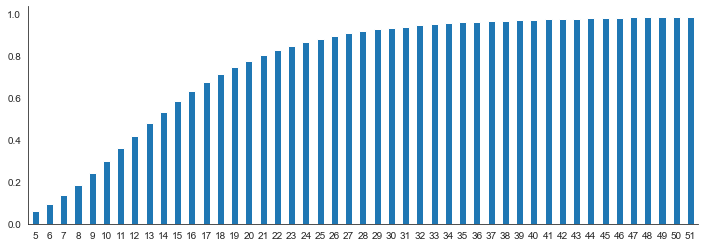

In [27]:
sent_length = pd.Series(dict(sent_length.most_common()))
with sns.axes_style("white"):
    sent_length.sort_index().cumsum().div(sent_length.sum()).loc[5:51].plot.bar(figsize=(12, 4), rot=0)
    sns.despine();

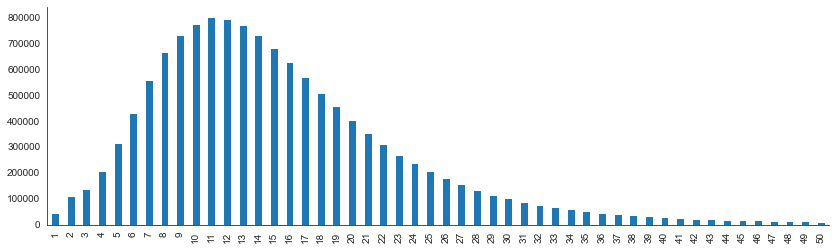

In [28]:
with sns.axes_style("white"):
    sent_length.sort_index().loc[:50].plot.bar(figsize=(14, 4))
    sns.despine();

In [29]:
# Create bi- and trigrams
files = selected_section_path.glob('*.txt')
texts = [f.read_text() for f in files]
unigrams = ngram_path / 'ngrams_1.txt'
unigrams.write_text('\n'.join(texts))

1665053825

In [30]:
texts = unigrams.read_text()

In [35]:
n_grams = []
start = time()
for i, n in enumerate([2, 3]):
    sentences = LineSentence(ngram_path / f'ngrams_{n-1}.txt')
    phrases = Phrases(sentences=sentences,
                      min_count=25,  # ignore terms with a lower count
                      threshold=0.5,  # accept phrases with higher score
                      max_vocab_size=4000000,  # prune of less common words to limit memory use
                      delimiter='_',  # how to join ngram tokens
                      scoring='npmi')

    s = pd.DataFrame([[k, v] for k, v in phrases.export_phrases().items()],
                     columns=['phrase', 'score']).assign(length=n)

    n_grams.append(s.groupby('phrase').score.agg(['mean', 'size']))
    print(n_grams[-1].nlargest(5, columns='size'))

    grams = Phraser(phrases)
    sentences = grams[sentences]
    (ngram_path / f'ngrams_{n}.txt').write_text('\n'.join([' '.join(s) for s in sentences]))

    src_dir = results_path / f'ngrams_{n-1}'
    target_dir = results_path / f'ngrams_{n}'
    if not target_dir.exists():
        target_dir.mkdir()

    for f in src_dir.glob('*.txt'):
        text = LineSentence(f)
        text = grams[text]
        (target_dir / f'{f.stem}.txt').write_text('\n'.join([' '.join(s) for s in text]))
    print('\n\tDuration: ', format_time(time() - start))

n_grams = pd.concat(n_grams).sort_values('size', ascending=False)
n_grams.to_parquet(results_path / 'ngrams.parquet')

              mean  size
phrase                  
aa_aa     0.571098     1
aa_baa    0.665149     1
aa_bbb    0.707244     1
aa_rated  0.547808     1
aaa_aa    0.726825     1

	Duration:  00:17:59
                mean  size
phrase                    
aa_aa       0.651564     1
aa_bbb      0.510896     1
aa_rated    0.592968     1
aaa_aa      0.806195     1
aaa_aa_baa  0.685790     1

	Duration:  00:32:32


In [36]:
n_grams.groupby(n_grams.index.str.replace('_', ' ').str.count(' ')).size()

phrase
1    48262
2     6020
3     1187
dtype: int64

In [37]:
# Convert filings to integer sequences based on token count
sentences = (ngram_path / 'ngrams_3.txt').read_text().split('\n')
n = len(sentences)

token_cnt = Counter()
for i, sentence in enumerate(sentences, 1):
    if i % 500000 == 0:
        print(f'{i/n:.1%}', end=' ', flush=True)
    token_cnt.update(sentence.split())

token_cnt = pd.Series(dict(token_cnt.most_common()))
token_cnt = token_cnt.reset_index()
token_cnt.columns = ['token', 'n']

4.0% 7.9% 11.9% 15.9% 19.9% 23.8% 27.8% 31.8% 35.8% 39.7% 43.7% 47.7% 51.7% 55.6% 59.6% 63.6% 67.6% 71.5% 75.5% 79.5% 83.5% 87.4% 91.4% 95.4% 99.4% 

In [38]:
token_cnt.to_parquet(results_path / 'token_cnt')
token_cnt.n.describe(deciles).apply(lambda x: f'{x:,.0f}')

count      188,061
mean           920
std         12,785
min              1
10%              1
20%              2
30%              4
40%              7
50%             12
60%             25
70%             41
80%             85
90%            288
max      1,716,595
Name: n, dtype: object

In [39]:
token_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188061 entries, 0 to 188060
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   188061 non-null  object
 1   n       188061 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [40]:
token_cnt.head()

,token,n
0,million,1716595
1,business,1032510
2,company,982713
3,products,963810
4,net,777581


In [41]:
token_cnt.nlargest(10, columns='n')

,token,n
0,million,1716595
1,business,1032510
2,company,982713
3,products,963810
4,net,777581
5,sales,767243
6,including,733801
7,market,730678
8,costs,701521
9,december,697590


In [42]:
token_cnt.sort_values(by=['n', 'token'], ascending=[False, True]).head()

,token,n
0,million,1716595
1,business,1032510
2,company,982713
3,products,963810
4,net,777581


In [43]:
token_by_freq = token_cnt.sort_values(by=['n', 'token'], ascending=[False, True]).token
token2id = {token: i for i, token in enumerate(token_by_freq, 3)}
len(token2id)

188061

In [45]:
for token, i in token2id.items():
    print(token, i)
    break

million 3


In [46]:
def generate_sequences(min_len=100, max_len=20000, num_words=25000, oov_char=2):
    if not vector_path.exists():
        vector_path.mkdir()
    seq_length = {}
    skipped = 0
    for i, f in tqdm(enumerate((results_path / 'ngrams_3').glob('*.txt'), 1)):
        file_id = f.stem
        text = f.read_text().split('\n')
        vector = [token2id[token] if token2id[token] + 2 < num_words else oov_char for line in text
                  for token in line.split()]
        vector = vector[:max_len]
        if len(vector) < min_len:
            skipped += 1
            continue
        seq_length[int(file_id)] = len(vector)
        np.save(vector_path / f'{file_id}.npy', np.array(vector))
    seq_length = pd.Series(seq_length)
    return seq_length

seq_length = generate_sequences()
seq_length.head()

15373it [02:16, 112.66it/s]


1        13580
10        9598
100      10845
1000     11890
10000     4556
dtype: int64

In [47]:
pd.Series(seq_length).to_csv(results_path / 'seq_length.csv')
seq_length.describe(deciles)

count    15172.000000
mean     10993.255800
std       5035.860079
min        121.000000
10%       4469.300000
20%       6480.200000
30%       8024.000000
40%       9332.800000
50%      10681.000000
60%      12055.600000
70%      13600.000000
80%      15675.600000
90%      18785.600000
max      20000.000000
dtype: float64

In [48]:
seq_length.sum()

166789677

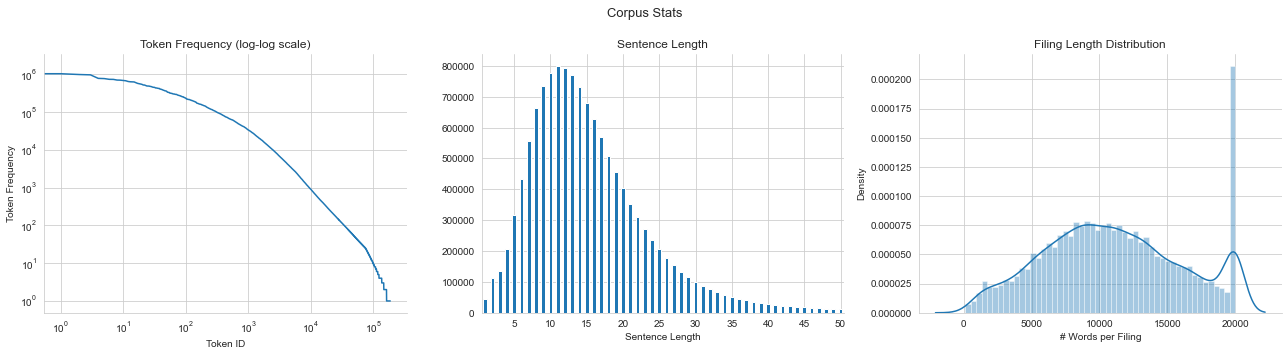

In [49]:
fig, axes = plt.subplots(ncols=3, figsize=(18,5))
token_cnt.n.plot(logy=True, logx=True, ax=axes[0], title='Token Frequency (log-log scale)')
sent_length.sort_index().loc[:50].plot.bar(ax=axes[1], rot=0, title='Sentence Length')

n=5
ticks = axes[1].xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in axes[1].xaxis.get_ticklabels()]
axes[1].xaxis.set_ticks(ticks[n-1::n])
axes[1].xaxis.set_ticklabels(ticklabels[n-1::n])
axes[1].set_xlabel('Sentence Length')

sns.distplot(seq_length, ax=axes[2], bins=50)
axes[0].set_ylabel('Token Frequency')
axes[0].set_xlabel('Token ID')

axes[2].set_xlabel('# Words per Filing')
axes[2].set_title('Filing Length Distribution')

fig.suptitle('Corpus Stats', fontsize=13)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'sec_seq_len', dpi=300);

In [50]:
files = vector_path.glob('*.npy')
filings = sorted([int(f.stem) for f in files])

In [51]:
# Prepare Model Data

# Create weekly forward returns
prices = pd.read_hdf(results_path / 'sec_returns.h5', 'prices')
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1297611 entries, 2013-09-16 to 2015-01-23
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   filing  1297611 non-null  int64  
 1   ticker  1297611 non-null  object 
 2   open    1297591 non-null  float64
 3   high    1297609 non-null  float64
 4   low     1297609 non-null  float64
 5   close   1297610 non-null  float64
 6   volume  1297610 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 79.2+ MB


In [52]:
fwd_return = {}
for filing in filings:
    date_filed = filing_index.at[filing, 'date_filed']
    price_data = prices[prices.filing==filing].close.sort_index()

    try:
        r = (price_data.pct_change(periods=5).shift(-5).loc[:date_filed].iloc[-1])
    except:
        continue
    if not np.isnan(r) and -.5 < r < 1: # ignoring outlier returns that below 50% or above 100%
        fwd_return[filing] = r
len(fwd_return)

15027

In [53]:
# Combine returns with filing data
y, X = [], []
for filing_id, fwd_ret in fwd_return.items():
    X.append(np.load(vector_path / f'{filing_id}.npy') + 2)
    y.append(fwd_ret)

y = np.array(y)
len(y), len(X)

(15027, 15027)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

In [55]:
# Pad sequences
maxlen = 20000
X_train = pad_sequences(X_train, truncating='pre', padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, truncating='pre', padding='pre', maxlen=maxlen)
X_train.shape, X_test.shape

((13524, 20000), (1503, 20000))

In [56]:
# Define Model Architecture
K.clear_session()

embedding_size = 100
input_dim = X_train.max() + 1
rnn = Sequential([
    Embedding(input_dim=input_dim, output_dim=embedding_size, input_length=maxlen, name='EMB'),
    BatchNormalization(name='BN1'),
    Bidirectional(GRU(32), name='BD1'),
    BatchNormalization(name='BN2'),
    Dropout(.1, name='DO1'),
    Dense(5, name='D'),
    Dense(1, activation='linear', name='OUT')
])

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EMB (Embedding)             (None, 20000, 100)        2500000   
                                                                 
 BN1 (BatchNormalization)    (None, 20000, 100)        400       
                                                                 
 BD1 (Bidirectional)         (None, 64)                25728     
                                                                 
 BN2 (BatchNormalization)    (None, 64)                256       
                                                                 
 DO1 (Dropout)               (None, 64)                0         
                                                                 
 D (Dense)                   (None, 5)                 325       
                                                                 
 OUT (Dense)                 (None, 1)                 6

In [57]:
rnn.compile(loss='mse', optimizer='Adam', metrics=[RootMeanSquaredError(name='RMSE'),
                     MeanAbsoluteError(name='MAE')])

# Train model
early_stopping = EarlyStopping(monitor='val_MAE', patience=5, restore_best_weights=True)

training = rnn.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),
                   callbacks=[early_stopping], verbose=1, workers=6)

Epoch 1/100
423/423 [==============================] - 718s 2s/step - loss: 0.1199 - RMSE: 0.3463 - MAE: 0.2141 - val_loss: 0.0092 - val_RMSE: 0.0958 - val_MAE: 0.0543
Epoch 2/100
423/423 [==============================] - 697s 2s/step - loss: 0.0249 - RMSE: 0.1577 - MAE: 0.0871 - val_loss: 0.0095 - val_RMSE: 0.0976 - val_MAE: 0.0568
Epoch 3/100
423/423 [==============================] - 699s 2s/step - loss: 0.0129 - RMSE: 0.1135 - MAE: 0.0659 - val_loss: 0.0081 - val_RMSE: 0.0902 - val_MAE: 0.0521
Epoch 4/100
423/423 [==============================] - 700s 2s/step - loss: 0.0085 - RMSE: 0.0922 - MAE: 0.0552 - val_loss: 0.0077 - val_RMSE: 0.0879 - val_MAE: 0.0503
Epoch 5/100
423/423 [==============================] - 694s 2s/step - loss: 0.0075 - RMSE: 0.0866 - MAE: 0.0524 - val_loss: 0.0078 - val_RMSE: 0.0881 - val_MAE: 0.0505
Epoch 6/100
423/423 [==============================] - 698s 2s/step - loss: 0.0071 - RMSE: 0.0844 - MAE: 0.0512 - val_loss: 0.0078 - val_RMSE: 0.0880 - val_MAE:

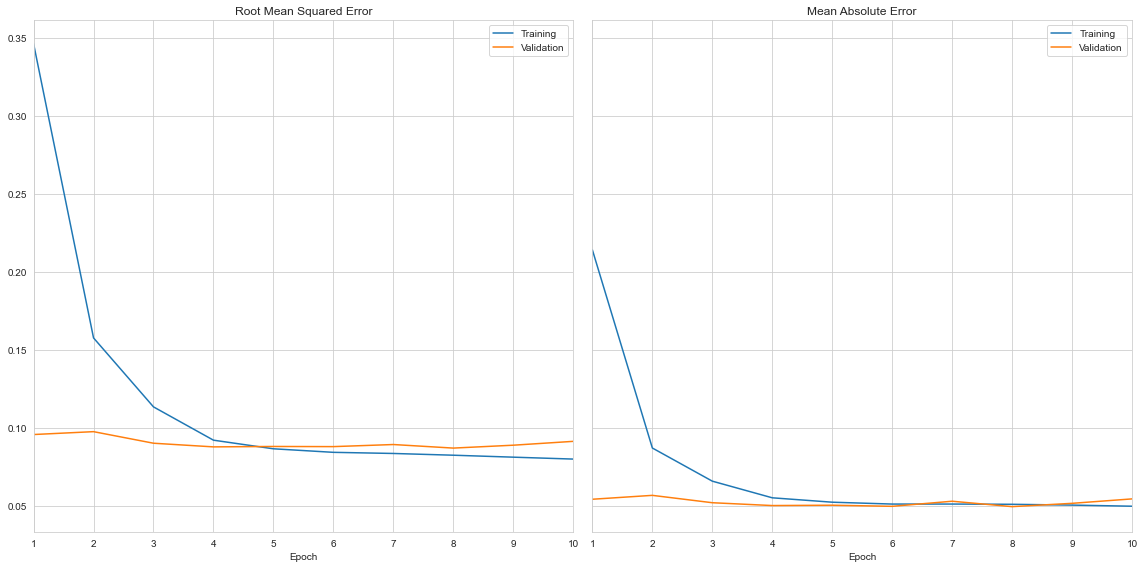

In [58]:
# Evaluate the Results
df = pd.DataFrame(training.history)
df.to_csv(results_path / 'rnn_sec.csv', index=False)
df.index += 1
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharey=True)
plot_data = (df[['RMSE', 'val_RMSE']].rename(columns={'RMSE': 'Training', 'val_RMSE': 'Validation'}))
plot_data.plot(ax=axes[0], title='Root Mean Squared Error')

plot_data = (df[['MAE', 'val_MAE']].rename(columns={'MAE': 'Training', 'val_MAE': 'Validation'}))
plot_data.plot(ax=axes[1], title='Mean Absolute Error')

for i in [0, 1]:
    axes[i].set_xlim(1, 10)
    axes[i].set_xlabel('Epoch')
fig.tight_layout()
fig.savefig(results_path / 'sec_cv_performance', dpi=300);

In [59]:
y_score = rnn.predict(X_test)
rho, p = spearmanr(y_score.squeeze(), y_test)
print(f'Information Coefficient: {rho*100:.2f} ({p:.2%})')

Information Coefficient: 2.05 (42.63%)


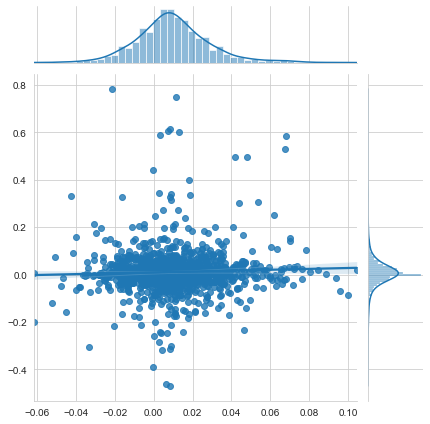

In [60]:
g = sns.jointplot(y_score.squeeze(), y_test, kind='reg');